<a href="https://colab.research.google.com/github/AnnaGolovaha/PyTorch_MNIST/blob/main/PyTorch_%D1%86%D0%B8%D1%84%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #для функций
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm #этот модуль нужен для того, чтобы видеть, что сейчас происходит в НС (учится она или нет)

In [2]:
trans = tv.transforms.Compose ([
    tv.transforms.ToTensor() #первод PIL изображения в тензор
]) #трансформация, которая объединяет несколько трансфомаций

In [ ]:
ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform = trans )

In [4]:
ds_mnist[0][0].numpy()[0].shape

(28, 28)

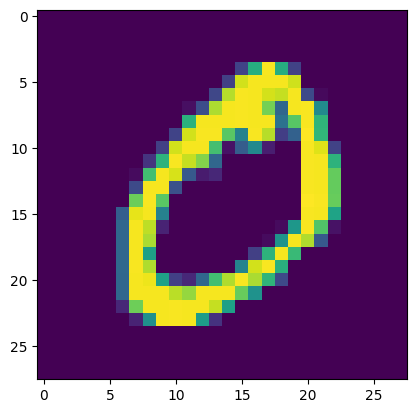

In [5]:
plt.imshow(ds_mnist[1][0].numpy()[0]) #рисуем первую картинку в датасете

#визуализировать можно именно numpy файл, для него мы убираем первую размерность [0]

In [6]:
batch_size = 16
dataloader = torch.utils.data. DataLoader(
    ds_mnist, batch_size = batch_size, shuffle = True,
    num_workers =1, drop_last = True #num_workers-кол-во потоков(0-все потоки), drop_last -чтобы не было маленьких батчей
    )

In [7]:
for img, label in dataloader:
  print(img.shape)
  print(label.shape)
  break

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [8]:
class Neural_numbers(nn.Module): #наследуем класс от nn.Module
  def __init__(self):
    super().__init__() #нужна, т.к. мы переписываем конструктор модуля, от которого наследуем (обращаемся к высшему классу, иначе будет ошибка)

# /////////////////// ПЕРВЫЙ ВАРИАНТ РЕАЛИЗАЦИИ МОДЕЛИ
    # linear1 = nn.Linear(28*28,100)
    # linear2 = nn.Linear(100,10)
    # act = nn.Relu()

  #   self.model = nn.Sequential(linear1, act, linear2)

  # def forward(self,x): #сначала передаём класс self, затем тензор
  #    return self.model(x)
# //////////////////

    # ВТОРОЙ ВАРИАНТ
    self.flat = nn.Flatten() #чтобы была правильная размерность (делаем один длинный вектор)
    self.linear1 = nn.Linear(28*28,100)
    self.linear2 = nn.Linear(100,10)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out

In [9]:
def count_parameers(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [10]:
model =  Neural_numbers()

In [11]:
count_parameers(model) #число параметров сети

79510

In [12]:
loss_fn = nn.CrossEntropyLoss()

In [13]:
optimazer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9) #стохастический градиентный спуск

In [14]:
def accuracy(pred, label):
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)

  # detach() удаляет граф вычислений (как бы историю) с тензора. Отвязывает.
# Back propagation не будет идти дальше этого тензора.

  return answer.mean()

In [15]:
epochs = 10

# for epoch in range(epochs):
#   loss_val = 0
#   acc_val = 0
#   # тут будут пачки по 16 сэмплов
#   for img, label in (pbar := tqdm(dataloader)): #для каждого изображения считается loss и градиент


for epoch in range(epochs):
  loss_val = 0
  acc_val = 0
  for img, label in (pbar := tqdm(dataloader)):
    optimazer.zero_grad()  #обновляем градиенты


    label = (torch.Tensor(F.one_hot(label, 10))).float() #здесь 16 тензоров по 10 значений(на нужном классе стоит 1)
    # label - это метка нужного класса, т.е. цифра от 1 до 10
    #  one_hot - эта функция создаст тензоры(по количеству картинок), в которых будут только 0, а 1 встанет на место под индексом, который равен label
    # количество label = кол-ву картинок, столько будет тензоров по 10 чисел в каждом(9 нулей и 1 единичка на нужном месте)

    pred = model(img) #здесь 10 значений (для каждого класса) в 16 тензорах(размер батча)

    loss = loss_fn(pred, label)

    loss.backward()
    loss_item = loss.item()
    loss_val += loss_item

    optimazer.step()

    acc_current = accuracy(pred, label)
    acc_val += acc_current #мы же выводим среднее, поэтому суммируем


    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')

  print(loss_val/len(dataloader))
  print(acc_val/len(dataloader))


  0%|          | 0/3750 [00:00<?, ?it/s]<ipython-input-14-1744ef0ade74>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.25106	accuracy: 0.938: 100%|██████████| 3750/3750 [00:35<00:00, 104.30it/s]


0.6406531504223744
0.8448


loss: 0.81185	accuracy: 0.875: 100%|██████████| 3750/3750 [00:35<00:00, 105.52it/s]


0.3150815931275487
0.9096833333333333


loss: 0.20347	accuracy: 0.938: 100%|██████████| 3750/3750 [00:36<00:00, 101.44it/s]


0.26814424701184036
0.9235166666666667


loss: 0.11453	accuracy: 1.000: 100%|██████████| 3750/3750 [00:35<00:00, 105.84it/s]


0.23370602405394117
0.93375


loss: 0.28235	accuracy: 0.938: 100%|██████████| 3750/3750 [00:34<00:00, 108.43it/s]


0.20671659050409993
0.9420333333333333


loss: 0.11868	accuracy: 0.938: 100%|██████████| 3750/3750 [00:35<00:00, 105.72it/s]


0.18463720703994235
0.9479


loss: 0.32335	accuracy: 0.938: 100%|██████████| 3750/3750 [00:34<00:00, 108.77it/s]


0.1668220275650422
0.9532333333333334


loss: 0.32694	accuracy: 0.938: 100%|██████████| 3750/3750 [00:35<00:00, 105.91it/s]


0.15146686922026179
0.9573666666666667


loss: 0.01030	accuracy: 1.000: 100%|██████████| 3750/3750 [00:35<00:00, 106.42it/s]


0.13863486265850564
0.9611


loss: 0.02018	accuracy: 1.000: 100%|██████████| 3750/3750 [00:36<00:00, 103.95it/s]

0.12842258078344165
0.9642


In [16]:
accuracy(pred, label)

<ipython-input-14-1744ef0ade74>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


1.0

In [38]:
# Загружаем тестовый датасет для проверки работы НС
import torchvision.datasets as datasets
mnist_test_dataset = datasets.MNIST(root='./datasets', train=False, transform=trans)
mnist_test_dataset[1][0].numpy()[0].shape

(28, 28)

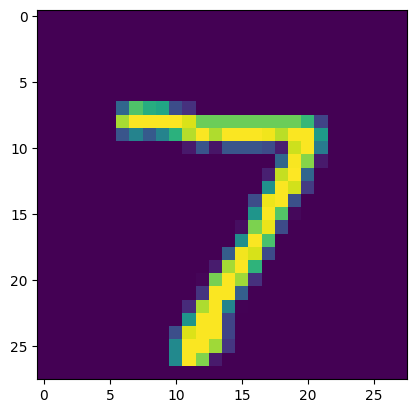

In [39]:
plt.imshow(mnist_test_dataset[0][0].numpy()[0]) #рисуем первую картинку в тестовом датасете

In [40]:
# проверка работы НС на тестовом изображении
test_img = mnist_test_dataset[0][0]
test_pred = model(test_img)
print(test_pred)

F.softmax(test_pred).detach().numpy().argmax() #можно закомментировать argmax и посмотреть вероятности

tensor([[  0.2654,  -6.5142,   3.8868,   5.5698,  -6.2383,   0.2873, -10.2248,
          11.1404,   0.7062,   2.5062]], grad_fn=<AddmmBackward0>)


<ipython-input-40-0fdc2aff9a43>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(test_pred).detach().numpy().argmax() #можно закомментировать argmax и посмотреть вероятности


7